In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import os
import itertools
import re

from tqdm import tqdm_notebook, tnrange

## 1. Model definition and traffic modelling

We consider two types of networks:

1. wireless network under DCF
2. wireless relay network (wired-like)

Bother networks have linear topology, have up to 10 stations, use similiar channel access parameters and transmit equal traffic.

In [3]:
PHY_HEADER = 128
MAC_HEADER = 272
IP_HEADER = 160
PREAMBLE = 0
ALL_HEADERS_SIZE = PHY_HEADER + MAC_HEADER + IP_HEADER

MAC_ACK = 112
SLOT = 50e-6
DIFS = 128e-6
SIFS = 28e-6
IFS = 128e-6  # equal to DIFS
CWMIN = 16
CWMAX = 1024
BITRATE = 1e6

SIM_TIME_DRAFT_LIMIT = 50
SIM_TIME_PRODUCTION_LIMIT = 150

PAYLOAD_UNIFORM_MIN = 2000
PAYLOAD_UNIFORM_MAX = 10688
PAYLOAD_MEAN = 0.5 * (PAYLOAD_UNIFORM_MIN + PAYLOAD_UNIFORM_MAX)

TRAFFIC = [20e3, 40e3, 60e3, 80e3, 120e3, 250e3, 500e3]
ARRIVAL_RATES = [traffic/PAYLOAD_MEAN for traffic in TRAFFIC]

MAX_STATIONS_NUM = 10

CMAP_NAME = 'viridis'

Since the properties precision estimated using Monte-Carlo or simulation modelling methods depends on the running time and the number of samples, we define two modes: **production** and **draft**. In the first mode, the simulations will take more time `SIM_TIME_PRODUCTION_LIMIT`, and in latter case - smaller amount `SIM_TIME_DRAFT_LIMIT`. To simplify things, we define `RUN_MODE` parameters, which takes values either `'production'` or `'draft'`, and which defines `SIM_TIME_LIMIT` variable.

In [4]:
RUN_MODE = 'production'  # 'draft' or 'production'

if RUN_MODE == 'draft':
    SIM_TIME_LIMIT = SIM_TIME_DRAFT_LIMIT
elif RUN_MODE == 'production':
    SIM_TIME_LIMIT = SIM_TIME_PRODUCTION_LIMIT
else:
    raise ValueError(f'unexpected RUN_MODE="{RUN_MODE}" value')

print(f'RUN_MODE is "{RUN_MODE}", SIM_TIME_LIMIT={SIM_TIME_LIMIT}')

RUN_MODE is "production", SIM_TIME_LIMIT=150


We are going to use sample traffic with high lag-1 coefficient. In our assumptions, traffic is composed of sequential fragments. In each fragment intervals are distributed normally with a given mean and std. values. It is like some applications send data through network within (large) intervals.

First, we build a sample sequence and normalize it, so in average the interval and rate are equal to one. Then we build a MAP using EM-procedure. While actual statistic properties may be fitted with rather high error, it is not very critical since they key thing is to have an arrival flow with non-zero correlation, and actual shape and fitting precision are not very critical.

Before doing that, we define several functions we are going to use here and in the following estimations.

In [5]:
from pyqumo.distributions import PhaseType

# Define some service functions we will be using
# here and below:
def rel_err(actual, expected):
    return np.abs(expected - actual) / expected if np.abs(expected) > 1e-6 else np.Inf
    
def print_estimations(nea_data):
    columns = ['Name', 'Expected', 'Actual', 'Std. Error']
    data = [(item[0], item[1], item[2], rel_err(item[2], item[1])) for item in nea_data]
    from tabulate import tabulate
    print(tabulate(data, headers=columns))

def relay_bits2time(n):
    """Convert bits to time needed to transmit these bits.
    """
    return PREAMBLE + (n + PHY_HEADER + MAC_HEADER + IP_HEADER) / BITRATE + IFS

def get_color(x):
    return cm.get_cmap(CMAP_NAME)(x)

def scale_map(map_flow, rate):
    """Scale MAP flow in a way it will have the given average rate.
    """
    koef = map_flow.mean() * rate
    D0 = map_flow.D0 * koef
    D1 = map_flow.D1 * koef
    return MAP(D0, D1)
    
def get_flow_info(flow):
    """Get a dictionary of key properties of a flow.
    """
    return {
        'mean': flow.mean(),
        'rate': 1 / flow.mean(),
        'std': flow.std(),
        'lag-1': flow.lag(1),
        'lag-2': flow.lag(2),
    }

def print_flow_fitting_stats(arrivals_shape, flow):
    headers = 'Param. name', 'Original value', 'Fitted flow value', 'Rel. error'
    sample_moments = stats.moment(arrivals_shape, 2)
    sample_mean = sample_moments[0]
    sample_std = np.sqrt(sample_moments[1] - sample_mean ** 2)
    sample_rate = 1 / sample_mean
    sample_lag1, sample_lag2 = stats.lag(arrivals_shape, 2)
    data = [
        ('mean', sample_mean, flow.mean(), rel_err(flow.mean(), sample_mean)),
        ('std', sample_std, flow.std(), rel_err(flow.std(), sample_std)),
        ('rate', sample_rate, flow.rate, rel_err(flow.rate, sample_rate)),
        ('lag-1', sample_lag1, flow.lag(1), rel_err(flow.lag(1), sample_lag1)),
        ('lag-2', sample_lag2, flow.lag(2), rel_err(flow.lag(2), sample_lag2)),
    ]
    print(tabulate(data, headers=headers))

def copy_ph(ph):
    return PhaseType(ph.subgenerator, ph.pmf0)

(<Figure size 936x288 with 2 Axes>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x1296346d8>,
  <matplotlib.axes._subplots.AxesSubplot at 0x12b69dc18>))

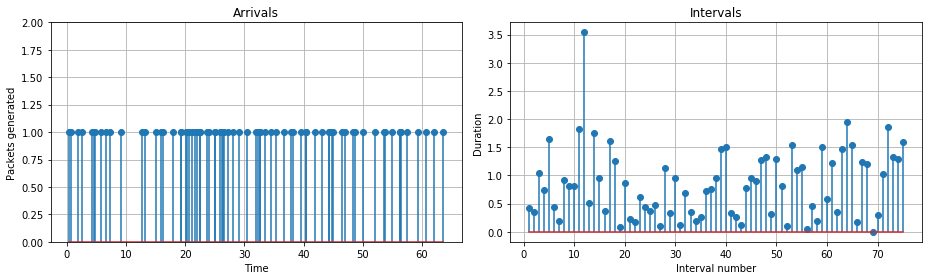

In [6]:
from pyqumo.arrivals import MAP
from pyqumo import stats
from tabulate import tabulate

def generate_packet_arrivals_shape(specs, iters=1):
    """Generate a traffic shape as a sequence of truncated normal distributed intervals with random size.
    
    Parameters:
    ::specs: an iterable, each component consists of `(mean, std, a, b)`, where `mean` adn `std` - 
        normal distribution parameters, `a` and `b` - low and high boundaries of the fragment size
    ::iter: how many times repeat fragments generation
    """
    ret = []
    for _ in range(iters):
        for mean, std, min_num, max_num in specs:
            fragment = np.abs(np.asarray(np.random.normal(mean, std, size=np.random.randint(min_num, max_num))))
            ret.extend(fragment)
    return ret

def display_packet_arrivals_shape(arrivals_shape, limit=-1):
    """Display two stem plots with intervals."""
    # First, we pring some stats:
    fig, (ax_t, ax_i) = plt.subplots(figsize=(13, 4), nrows=1, ncols=2)
    intervals = np.asarray(arrivals_shape[:limit])
    moments = np.cumsum(intervals)
    impulses = [1] * len(moments)
    ax_t.stem(moments, impulses, use_line_collection=True)
    ax_t.set_title('Arrivals')
    ax_t.set_xlabel('Time')
    ax_t.set_ylabel('Packets generated')
    ax_t.set_ylim((0, 2))
    ax_t.grid()
    ax_i.set_title('Intervals')
    ax_i.set_xlabel('Interval number')
    ax_i.set_ylabel('Duration')
    ax_i.stem(range(1, len(intervals) + 1), intervals, use_line_collection=True)
    ax_i.grid()
    plt.tight_layout()
    return fig, (ax_t, ax_i)

arrivals_shape = generate_packet_arrivals_shape(((1.0, 2.5, 5, 20),), iters=100)

def normalize_intervals_shape(intervals_shape):
    mean = np.mean(intervals_shape)
    return [x / mean for x in intervals_shape]

normalized_arrivals_shape = normalize_intervals_shape(arrivals_shape)
display_packet_arrivals_shape(normalized_arrivals_shape, limit=75)

Now we fit MAP by using generalized moments method. The fitted MAP will contain 8 states and will be normalized. When we fit it, we normalize it so it will have the rate 1.0. Afterwards the fitted normalized MAP will be displayed with fitting statistics and stem plots.

When we will actually define arrival MAP, we will scale this MAP to a given rate.

Param. name      Original value    Fitted flow value    Rel. error
-------------  ----------------  -------------------  ------------
mean                  1                    1           2.22045e-16
std                   0.773086             0.773086    3.75873e-08
rate                  1                    1           2.22045e-16
lag-1                 0.0156314            0.0156314   1.34815e-06
lag-2                -0.0227132           -0.0227132  -1.63132e-08
--------------------------------------------------------------------------------
FITTED NORMALIZED MAP
--------------------------------------------------------------------------------
D0:
[[-2.57  0.    0.    0.    0.    0.    0.  ]
 [ 0.04 -3.84  0.16  1.5   0.    0.74  0.87]
 [ 0.05  0.84 -3.    1.13  0.03  0.16  0.71]
 [ 0.11  0.03  0.   -3.06  0.    2.86  0.04]
 [ 0.01  0.23  0.19  1.14 -3.38  0.08  0.52]
 [ 2.06  0.    0.    0.    0.   -2.73  0.  ]
 [ 0.46  1.24  0.23  1.76  0.06  0.79 -5.07]]
D1:
[[0.   0.09 0.14 0.   2

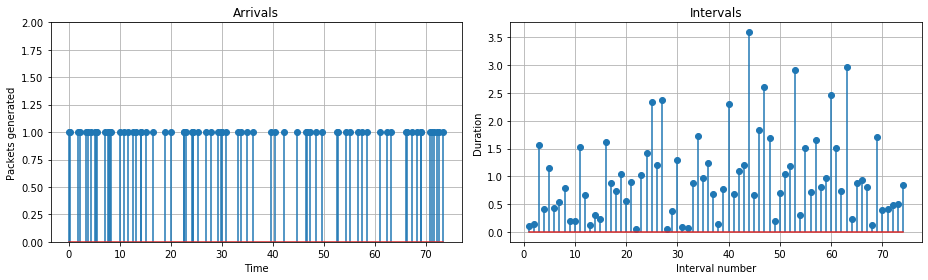

In [7]:
from pyqumo.fitting import fit_map

#
# Fit and normalize MAP:
#
fitted_arrival_map     = fit_map(arrivals_shape, order=7, method='opt')
normalized_arrival_map = scale_map(fitted_arrival_map, rate=1.0)
del fitted_arrival_map  # do not flood namespace :)

#
# Display fitting statistics and show stem plots with intervals:
#
print_flow_fitting_stats(normalized_arrivals_shape, normalized_arrival_map)
display_packet_arrivals_shape(list(normalized_arrival_map.generate(75)))

#
# Print matrices:
#
print(f'{"-"*80}\nFITTED NORMALIZED MAP\n{"-"*80}')
np.set_printoptions(precision=2, linewidth=140, suppress=True)
print(f'D0:\n{normalized_arrival_map.D0}')
print(f'D1:\n{normalized_arrival_map.D1}')

## 2. Relay network

First, we will study the relay network performance under the MAP traffic. In the network performance estimation we will use three techniques:

1. Simulation model for relay network;
2. Queueing tandem $MAP/PH/1/N \rightarrow \dots \bullet/PH/1/N$ with Monte-Carlo estimations;
3. Iterative procedure for queueing tandem properties estimation with departure process approximation.

But before diving into tandem performance estimation, we need to find out PH distributions we will be using in the queueing tandem network.

### 2.1. Relay channel delay fitting

The transmission in relay channel is straight-forward:

1. The transmitter builds a frame by adding IP header, MAC header, PHY header and prefexing with preamble;
2. The frame is being transmitted with constant bitrate;
3. The transmitter waits for `IFS` interval before sending another frame.

To simplify things, we will assume that the transmitter always waits `IFS` after the frame transmission, without considering the queue size after transmission ends. In this sample model, the only source of randomness is frame payload bitsize. While average end-to-end delays and utilization rates are not expected to be strongly affected by varying the frame size distributions with the same mean values, queue sizes may change. To study this effect, we define three different payload size distributions:

1. Constant distribution with `PAYLOAD_MEAN` value;
2. Unifrom distribution between `PAYLOAD_UNIFORM_MIN` and `PAYLOAD_UNIFORM_MAX`;
3. Exponential distribution with `PAYLOAD_MEAN` mean value.

We will build PH distribution by fitting delay samples for each payload size distribution. Since it is very easy to calculate mean and standard deviation, we will fit PH using moments method.

If $\xi$ is a random variable, which value is the payload size, then the delay $\tau$ is defined as:

$$
\tau = \text{IFS} + \text{P} + \frac{1}{B}(\text{H} + \xi),
$$

where IFS, P, H and B are constants equal to IFS, preamble duration, sum of all headers sizes and bitrate respectively. Then, mean, variance and standard deviation can be found:

$$
\begin{aligned}
\mathbb{E}\tau &= \text{IFS} + \text{P} + \frac{1}{B}(\mathbb{E}\xi + \text{H})\\
Var(\tau) &= \frac{1}{B^2}Var(\xi)\\
\sigma_\tau &= \frac{1}{B}\sigma_\xi
\end{aligned}
$$

In [8]:
from pyqumo.distributions import Exponential, Uniform, Constant, LinearTransform

# Define payload size distributions:
payload_size_distributions = {
    'const': Constant(PAYLOAD_MEAN),
    'uniform': Uniform(PAYLOAD_UNIFORM_MIN, PAYLOAD_UNIFORM_MAX),
    'exp': Exponential(PAYLOAD_MEAN),
}

# Then we can define relay channel delays distributions as LinearTransform
# with k=(1/BITRATE), b=(IFS + PREAMBLE + ALL_HEADERS_SIZE/BITRATE):
relay_channel_distributions = {
    name: LinearTransform(
        xi=payload_distribution,
        k=(1/BITRATE),
        b=(IFS + PREAMBLE + ALL_HEADERS_SIZE/BITRATE)
    ) for name, payload_distribution in payload_size_distributions.items()
}

In [9]:
from pyqumo.fitting import fit_ph_moments

# Now we fit PH distributions:
relay_channel_ph = {}
for name, dist in tqdm_notebook(relay_channel_distributions.items(), desc=f'Fitting PH'):
    moments = [dist.moment(1), dist.moment(2)]
    relay_channel_ph[name] = fit_ph_moments(moments, order=5)

# And output the moments and relative errors, and plot distributions:
def print_ph_fitting_statistics():
    nea_data = []
    for name, ph in relay_channel_ph.items():
        orig = relay_channel_distributions[name]
        nea_data.append((f'{name.capitalize()} mean', orig.mean(), ph.mean()))
        nea_data.append((f'{name.capitalize()} std.', orig.std(), ph.std()))    
    print_estimations(nea_data)

print_ph_fitting_statistics()


Name            Expected      Actual     Std. Error
------------  ----------  ----------  -------------
Const mean    0.007032    0.00652163    0.0725787
Const std.    0           0.00291674  inf
Uniform mean  0.007032    0.00685589    0.025044
Uniform std.  0.00250801  0.0030661     0.222524
Exp mean      0.007032    0.007032      9.66284e-13
Exp std.      0.006344    0.006344      8.15408e-13


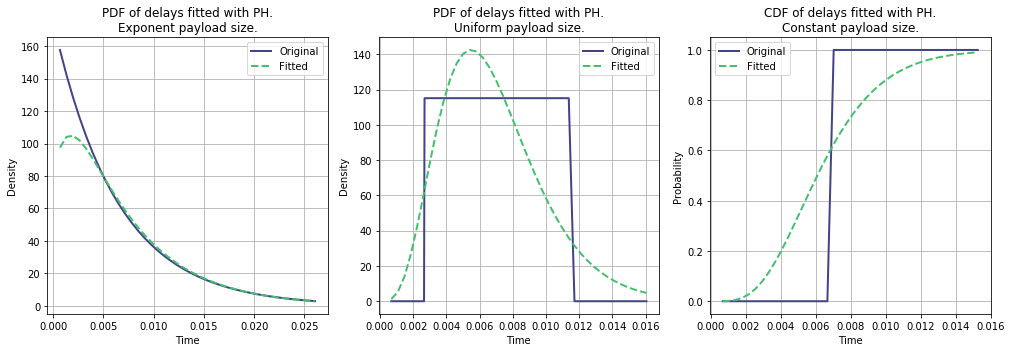

In [10]:
def plot_fitted_distribution(ax, dist, fitted, num_samples=40, add_points=(), fn='pdf', 
                             xlabel='Time', title='', min_x=0, max_x=None):
    assert fn.lower() in {'pdf', 'cdf'}
    max_x = fitted.mean() + 3 * fitted.std() if max_x is None else max_x
    ox = list(np.linspace(min_x, max_x, num_samples)) + list(add_points)
    ox.sort()
    ax.plot(ox, [getattr(dist, fn)(x) for x in ox], label='Original', linewidth=2, 
            color=get_color(0.2), linestyle='-')
    ax.plot(ox, [getattr(fitted, fn)(x) for x in ox], label='Fitted', linewidth=2, 
            color=get_color(0.7), linestyle='--')
    ax.grid()
    ax.legend()
    ax.set_ylabel('Density' if fn=='pdf' else 'Probability')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)

# Plotting fitting result for exponential distribution:
plot_fitted_distribution(
    axes[0], relay_channel_distributions['exp'], relay_channel_ph['exp'],
    title='PDF of delays fitted with PH.\nExponent payload size.',
    min_x=(IFS + PREAMBLE + ALL_HEADERS_SIZE/BITRATE),
)

# Plotting fitting result for uniform distribution. Here we also add uniform interval bounds:
plot_fitted_distribution(
    axes[1], relay_channel_distributions['uniform'], relay_channel_ph['uniform'],
    title='PDF of delays fitted with PH.\nUniform payload size.',
    min_x=(IFS + PREAMBLE + ALL_HEADERS_SIZE/BITRATE),
    add_points=(
        IFS + PREAMBLE + (ALL_HEADERS_SIZE + PAYLOAD_UNIFORM_MIN) / BITRATE,
        IFS + PREAMBLE + (ALL_HEADERS_SIZE + PAYLOAD_UNIFORM_MAX) / BITRATE,
    )
)

# Since it is hard to plot impulse function in generalized way, we plot CDF instead of
# PDF for constant service times:
plot_fitted_distribution(
    axes[2], relay_channel_distributions['const'], relay_channel_ph['const'], 
    title='CDF of delays fitted with PH.\nConstant payload size.',
    min_x=(IFS + PREAMBLE + ALL_HEADERS_SIZE/BITRATE),
    add_points=(relay_channel_distributions['const'].mean(),),
    fn='cdf',
)

plt.tight_layout()

### 2.2. Relay network simulation

Since we have arrival normalized MAP, we can scale it to actual rate using `ARRIVAL_RATES[i] = TRAFFIC[i] / PAYLOAD_MEAN`.

> Note, that in network simulation we do not use PH distributions, since station delays are defined in transmition process simulation. Instead, we use actual payload size distributions.

We will simulate traffic arrival at the first station, and vary the network length from 1 to `MAX_STATIONS_NUM` for each arrival rate.

Since there are no collisions in relay network, we are not interested in traffic with very small bitrates. To simplify simulation, we use only the four largest traffic values and define `RELAY_TRAFFIC` and `RELAY_TRAFFIC_RATES` constants containing the selected values.

In [11]:
from collections import namedtuple
from itertools import product
from pydesim import Logger

NUM_STATIONS_RANGE = range(1, MAX_STATIONS_NUM + 1)
RELAY_TRAFFIC = TRAFFIC[-4:]
RELAY_ARRIVAL_RATES = [traffic / PAYLOAD_MEAN for traffic in RELAY_TRAFFIC]

In [12]:
from pycsmaca.simulations.shortcuts import wired_line_network

RelayNetworkSimulationRecord = namedtuple('RelayNetworkSimulationRecord', [
    'data', 'num_stations', 'arrival_rate', 'payload_size'
])

relay_network_simulations = []  # each item will hold a namedtuple RelayNetworkSimulationRecord

for n, rate, payload in tqdm_notebook(
    list(product(NUM_STATIONS_RANGE, RELAY_ARRIVAL_RATES, payload_size_distributions.values())), 
    desc=f'Relay network simulation'
):
    arrival = scale_map(normalized_arrival_map, rate)
    data = wired_line_network(
        num_clients=n, 
        payload_size=payload,
        source_interval=arrival,
        active_sources=[0],
        header_size=ALL_HEADERS_SIZE,
        bitrate=BITRATE,
        preamble=PREAMBLE,
        ifs=IFS,
        queue_capacity=10,
        distance=100,
        sim_time_limit=SIM_TIME_LIMIT, 
        log_level=Logger.Level.WARNING,
    )
    record = RelayNetworkSimulationRecord(data=data, num_stations=n, arrival_rate=rate, payload_size=payload)
    relay_network_simulations.append(record)

### 2.3. Relay network modelling with queueing tandem network

Now we define a queueing tandem network and estimate its properties using two approaches:

1. **Monte-Carlo estimation:** a simulation of a queueing network to estimate its parameters.
2. **Departure approximation:** iterative estimation with departure flows approximation.

The latter approach will be used twice: in the first attempt we approximate departure MAPs with simple Poisson process (or MAP(1)) and in the second attempt we will use MAP of larger order.

#### 2.3.1. Monte-Carlo estimation

The procedure is similiar to relay network simulation: we run queueing network simulations, but using the fitted PH-distributed transmission delays as service time instead of providing payload size distributions. The queue capacity will be the same as in relay network simulation.

In [13]:
from pyqumo.qsim import tandem_queue_network

RelayQueueNetworkSimulationRecord = namedtuple('RelayNetworkSimulationRecord', [
    'data', 'num_stations', 'arrival_rate', 'service_time', 'traffic_name',
])

relay_queue_network_simulations = []  # each item will hold a namedtuple RelayQueueNetworkSimulationRecord

for n, rate, (traffic_name, channel_ph) in tqdm_notebook(
    list(product(NUM_STATIONS_RANGE, RELAY_ARRIVAL_RATES, relay_channel_ph.items())),
    desc=f'Queueing network simulation'
):
    arrivals = [scale_map(normalized_arrival_map, rate)] + [None] * (n - 1)
    services = [copy_ph(channel_ph) for _ in range(n)]
    data = tandem_queue_network(arrivals, services, queue_capacity=10, stime_limit=SIM_TIME_LIMIT)
    record = RelayQueueNetworkSimulationRecord(
        data=data, num_stations=n, arrival_rate=rate, service_time=channel_ph, traffic_name=traffic_name
    )
    relay_queue_network_simulations.append(record)

#### 2.3.2. Iterative approximation

In thie method, we approximate departure process in iterative procedure for estimation of delays, queue sizes and servers utilizations.

Since here we do not simulate the whole network, results for network of size `n` is obtained at $n$-th iteration of the estimation procedure.

In [14]:
from pyqumo.queues import MapPh1N
from pyqumo.arrivals import MAP

RELAY_APPROX_ORDERS = [1, 3]

ApproxQueueData = namedtuple('ApproxQueueData', [
    'delay', 'response_time', 'queue_wait', 'queue_size', 'utilization', 'system', 'departure', 'approx_departure'
])

RelayQueueNetworkApproxRecord = namedtuple('RelayNetworkSimulationRecord', [
    'data', 'num_stations', 'arrival_rate', 'service_time', 'traffic_name', 'approx_order',
])

relay_queue_network_approximations = []  # each item will hold a namedtuple RelayQueueNetworkSimulationRecord

def estimate_noct_approx_delay(stations_range, arrival, service, approx_order):
    stations = {}
    delay = 0.0
    for n in tqdm_notebook(stations_range, desc=f'Approximation, order={approx_order}', leave=False):
        # Building MAP/PH/1/N queueing system:
        qs = MapPh1N(arrival=arrival, service=service, capacity=10)
        
        # Fitting departure process with a MAP of a given order:
        if approx_order == 1:
            approx_departure = MAP.exponential(qs.departure.rate)
        else:
            approx_departure = fit_map(qs.departure, order=approx_order)

        # Extracting and recording properties:
        delay += qs.response_time
        stations[n] = ApproxQueueData(
            delay=delay, response_time=qs.response_time, queue_wait=qs.wait_time,
            queue_size=(qs.system_size_avg - qs.utilization), utilization=qs.utilization,
            system=qs, departure=qs.departure, approx_departure=approx_departure
        )

        # Setting next arrival equal to approximated departure MAP and moving to next iteration:
        arrival = approx_departure
    return stations

for rate, (traffic_name, channel_ph), approx_order in tqdm_notebook(
    list(product(RELAY_ARRIVAL_RATES, relay_channel_ph.items(), RELAY_APPROX_ORDERS)),
    desc=f'Queueing network approximations'
):
    arrival = scale_map(normalized_arrival_map, rate)
    stations = estimate_noct_approx_delay(NUM_STATIONS_RANGE, arrival, channel_ph, approx_order)
    records = [RelayQueueNetworkApproxRecord(
        data=data, num_stations=n, arrival_rate=rate, service_time=channel_ph, 
        traffic_name=traffic_name, approx_order=approx_order
    ) for n, data in stations.items()]
    relay_queue_network_approximations.extend(records)

### 2.4. Comparing results

Now we can compare the results for different traffic types. We will be interested in three parameters:

1. End-to-end delay
2. Average queue size
3. Utilization (busy ratio)

To compare, we will plot the results for each interesting metric.

#### 2.4.1. End-to-end delays

The key metric is end-to-end delay, since it is the most critical for many applications like VoIP, data streaming and others. 

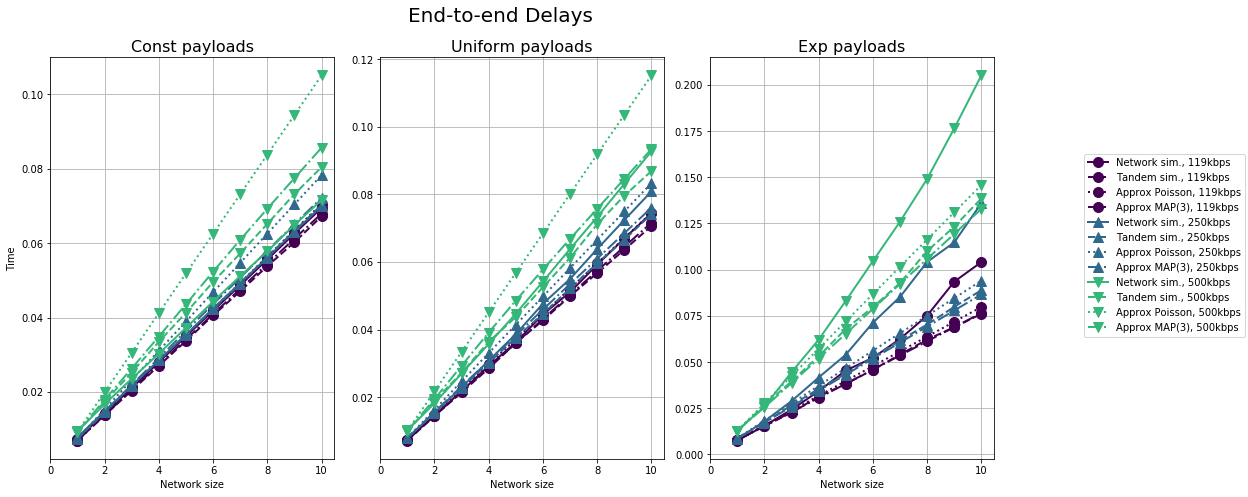

In [15]:
fig, axes = plt.subplots(figsize=(14, 7), ncols=3)

all_markers = ['o', '^', 'v', 'x', '<', '>', 's']

def plot_relay_delays(ax, rates, payload_dist_name):
    for i, (rate, marker) in enumerate(zip(rates, all_markers)):
        net_sim = [rec for rec in relay_network_simulations if (
            rec.arrival_rate == rate and rec.payload_size == payload_size_distributions[payload_dist_name]
        )]
        q_sim = [rec for rec in relay_queue_network_simulations if (
            rec.arrival_rate == rate and rec.traffic_name == payload_dist_name
        )]
        q_approx_1 = [rec for rec in relay_queue_network_approximations if (
            rec.arrival_rate == rate and rec.traffic_name == payload_dist_name and rec.approx_order == 1
        )]
        q_approx_3 = [rec for rec in relay_queue_network_approximations if (
            rec.arrival_rate == rate and rec.traffic_name == payload_dist_name and rec.approx_order == 3
        )]
        
        color = get_color(i / len(rates))
        tb = int(rate * PAYLOAD_MEAN / 1e3)
        
        ax.plot(NUM_STATIONS_RANGE, [r.data.clients[0].delay.mean() for r in net_sim],
                color=color, linewidth=2, linestyle='-', marker=marker, markersize=10,
                label=f'Network sim., {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [r.data.nodes[0].delay.mean() for r in q_sim],
                color=color, linewidth=2, linestyle='--', marker=marker, markersize=10,
                label=f'Tandem sim., {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [r.data.delay for r in q_approx_1],
                color=color, linewidth=2, linestyle=':', marker=marker, markersize=10,
                label=f'Approx Poisson, {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [r.data.delay for r in q_approx_3],
                color=color, linewidth=2, linestyle='-.', marker=marker, markersize=10,
                label=f'Approx MAP(3), {tb}kbps')
            
        
    ax.set_xlabel('Network size')
    ax.set_title(f'{payload_dist_name.capitalize()} payloads', fontsize=16)
    ax.set_xticks(np.linspace(0, 10, 6))
    ax.grid()

axes[0].set_ylabel('Time')
plot_relay_delays(axes[0], RELAY_ARRIVAL_RATES[-3:], 'const')
plot_relay_delays(axes[1], RELAY_ARRIVAL_RATES[-3:], 'uniform')
plot_relay_delays(axes[2], RELAY_ARRIVAL_RATES[-3:], 'exp')
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=1, bbox_to_anchor=(1.24, 0.5))
plt.suptitle('End-to-end Delays', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

#### 2.4.2. Average queue size and utilization

These metrics represent the memory and load properties of the networks.

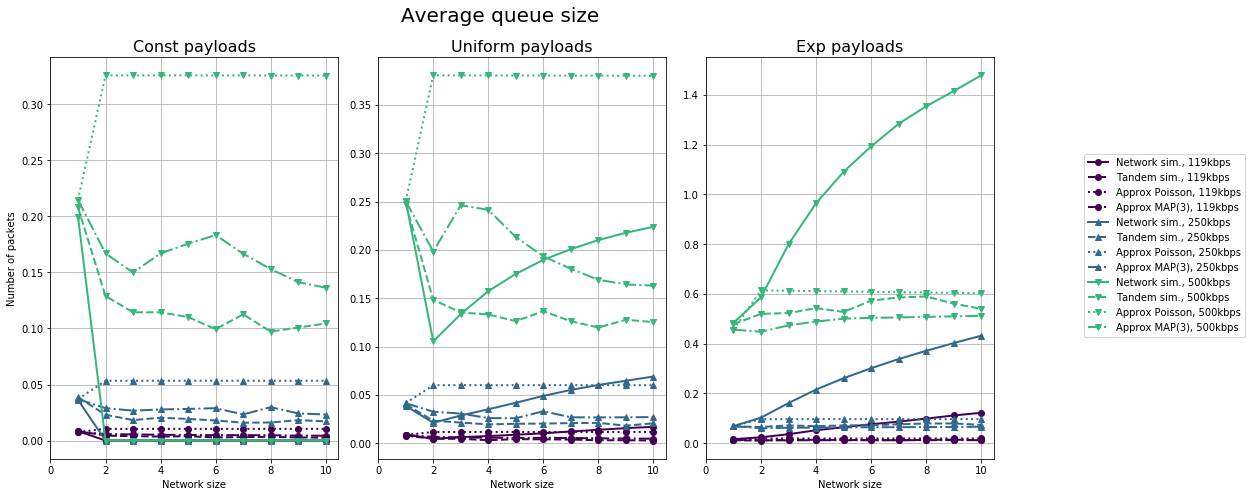

In [16]:
fig, axes = plt.subplots(figsize=(14, 7), ncols=3)

all_markers = ['o', '^', 'v', 'x', '<', '>', 's']

def plot_relay_delays(ax, rates, payload_dist_name):
    for i, (rate, marker) in enumerate(zip(rates, all_markers)):
        net_sim = [rec for rec in relay_network_simulations if (
            rec.arrival_rate == rate and 
            rec.payload_size == payload_size_distributions[payload_dist_name] and
            rec.num_stations == MAX_STATIONS_NUM
        )][0]
        q_sim = [rec for rec in relay_queue_network_simulations if (
            rec.arrival_rate == rate and 
            rec.traffic_name == payload_dist_name and
            rec.num_stations == MAX_STATIONS_NUM
        )][0]
        q_approx_1 = [rec for rec in relay_queue_network_approximations if (
            rec.arrival_rate == rate and rec.traffic_name == payload_dist_name and rec.approx_order == 1
        )]
        q_approx_3 = [rec for rec in relay_queue_network_approximations if (
            rec.arrival_rate == rate and rec.traffic_name == payload_dist_name and rec.approx_order == 3
        )]
        
        color = get_color(i / len(rates))
        tb = int(rate * PAYLOAD_MEAN / 1e3)
        
        ax.plot(NUM_STATIONS_RANGE, [net_sim.data.clients[n-1].queue_size.timeavg() for n in NUM_STATIONS_RANGE],
                color=color, linewidth=2, linestyle='-', marker=marker, markersize=6,
                label=f'Network sim., {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [q_sim.data.nodes[n-1].queue_size.timeavg() for n in NUM_STATIONS_RANGE],
                color=color, linewidth=2, linestyle='--', marker=marker, markersize=6,
                label=f'Tandem sim., {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [r.data.queue_size for r in q_approx_1],
                color=color, linewidth=2, linestyle=':', marker=marker, markersize=6,
                label=f'Approx Poisson, {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [r.data.queue_size for r in q_approx_3],
                color=color, linewidth=2, linestyle='-.', marker=marker, markersize=6,
                label=f'Approx MAP(3), {tb}kbps')
        
    ax.set_xlabel('Network size')
    ax.set_title(f'{payload_dist_name.capitalize()} payloads', fontsize=16)
    ax.set_xticks(np.linspace(0, 10, 6))
    ax.grid()

axes[0].set_ylabel('Number of packets')
plot_relay_delays(axes[0], RELAY_ARRIVAL_RATES[-3:], 'const')
plot_relay_delays(axes[1], RELAY_ARRIVAL_RATES[-3:], 'uniform')
plot_relay_delays(axes[2], RELAY_ARRIVAL_RATES[-3:], 'exp')
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=1, bbox_to_anchor=(1.24, 0.5))
plt.suptitle('Average queue size', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

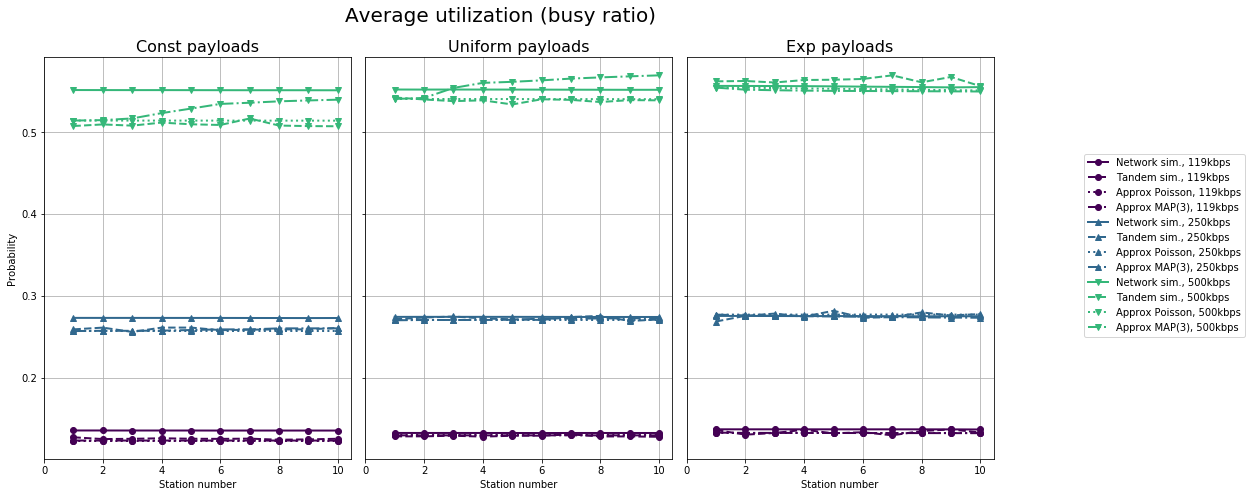

In [17]:
fig, axes = plt.subplots(figsize=(14, 7), ncols=3, sharey=True)

ALL_MARKERS = ['o', '^', 'v', 'x', '<', '>', 's']

def plot_relay_delays(ax, rates, payload_dist_name):
    for i, (rate, marker) in enumerate(zip(rates, all_markers)):
        net_sim = [rec for rec in relay_network_simulations if (
            rec.arrival_rate == rate and 
            rec.payload_size == payload_size_distributions[payload_dist_name] and
            rec.num_stations == MAX_STATIONS_NUM
        )][0]
        q_sim = [rec for rec in relay_queue_network_simulations if (
            rec.arrival_rate == rate and 
            rec.traffic_name == payload_dist_name and
            rec.num_stations == MAX_STATIONS_NUM
        )][0]
        q_approx_1 = [rec for rec in relay_queue_network_approximations if (
            rec.arrival_rate == rate and rec.traffic_name == payload_dist_name and rec.approx_order == 1
        )]
        q_approx_3 = [rec for rec in relay_queue_network_approximations if (
            rec.arrival_rate == rate and rec.traffic_name == payload_dist_name and rec.approx_order == 3
        )]
        
        color = get_color(i / len(rates))
        tb = int(rate * PAYLOAD_MEAN / 1e3)
        
        ax.plot(NUM_STATIONS_RANGE, [net_sim.data.clients[n-1].tx_busy.timeavg() for n in NUM_STATIONS_RANGE],
                color=color, linewidth=2, linestyle='-', marker=marker, markersize=6,
                label=f'Network sim., {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [q_sim.data.nodes[n-1].busy.timeavg() for n in NUM_STATIONS_RANGE],
                color=color, linewidth=2, linestyle='--', marker=marker, markersize=6,
                label=f'Tandem sim., {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [r.data.utilization for r in q_approx_1],
                color=color, linewidth=2, linestyle=':', marker=marker, markersize=6,
                label=f'Approx Poisson, {tb}kbps')
        ax.plot(NUM_STATIONS_RANGE, [r.data.utilization for r in q_approx_3],
                color=color, linewidth=2, linestyle='-.', marker=marker, markersize=6,
                label=f'Approx MAP(3), {tb}kbps')
        
    ax.set_xlabel('Station number')
    ax.set_xticks(np.linspace(0, 10, 6))    
    ax.set_title(f'{payload_dist_name.capitalize()} payloads', fontsize=16)
    ax.grid()

axes[0].set_ylabel('Probability')
plot_relay_delays(axes[0], RELAY_ARRIVAL_RATES[-3:], 'const')
plot_relay_delays(axes[1], RELAY_ARRIVAL_RATES[-3:], 'uniform')
plot_relay_delays(axes[2], RELAY_ARRIVAL_RATES[-3:], 'exp')
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='right', ncol=1, bbox_to_anchor=(1.24, 0.5))
plt.suptitle('Average utilization (busy ratio)', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.88)

The results shown here are mostly expected, since the relay network queueing model is very close to the origin: the largest part of service time is devoted to the payload transmission, and payload size is proportional to its transmission time. So the wireless network behaviour is very close to the queueing system behaviour.

Exactly, it is easy to estimate the average rate of service time devoted to payload transmission:

In [18]:
_relay_total_transmission_time = (ALL_HEADERS_SIZE + PAYLOAD_MEAN) / BITRATE + PREAMBLE + IFS
_payload_transmission_time = PAYLOAD_MEAN / BITRATE
_relay_payload_time_fraction = _payload_transmission_time / _relay_total_transmission_time

print(f'Average fraction of time devoted to payload transmission is {_relay_payload_time_fraction:.2f}')

Average fraction of time devoted to payload transmission is 0.90


The main difference with a classic queueing network is the fixed service time for each packet: since the payload size is constant for each packet, and all headers and intervals are also fixed, the packet transmission time is constant. However, when modelling a relay network with a queueing system, we assume independent service times at each node.

This causes errors in queue size estimations: for instance, when all packets have the same size, obviously the "real" queue size is zero. However, we model service time with a PH distribution with non-zero CV (coefficient of variance), and in queueing network queue sizes are not zero anymore. Due to this reason, errors appear in queue sizes and service time estimations under high utilization.

## 2. DCF Network

Now we are going to study a multihop wireless network with stations using a basic version of IEEE 802.11 DCF (Distributed Coordination Function). In contrast to a relay network, DCF stations transmissions may face collisions, when neighbours transmit simultaneously.

Another difference with relay network is randomness in channel waiting times introduced by the exponential backoff. Also the fraction of payload (successful) transmission to the total time the packet was being served is much smaller then in case of relay network.

> **TODO**: estimate the fraction of time using Bianchi model

However, since any collision at one station is simultaneous with a collision at another neighbour station, the service may be correlated. To analyze how well can classic independent queueing model approximate multi-hop network properties, we run the experiment below.

### 2.1. DCF channel fitting

Since we are interest in non-saturated mode, we simulate DCF under non-saturate conditions and get the service time distribution. Since the collision probability depends on the packets arrival rate, we expect that distributions for different bitrates will differ. However, we expect less dependency on actual payload shape. 

To simplify things, we consider only uniform-distributed payload sizes.

In [19]:
from pycsmaca.simulations.shortcuts import collision_domain_network
from pyqumo.distributions import Uniform
from collections import namedtuple
from itertools import product

DCF_CHAN_MAX_NUM_STATIONS   = 5
DCF_CHAN_NUM_STATIONS_RANGE = range(1, DCF_CHAN_MAX_NUM_STATIONS+1)
DCF_TRAFFIC                 = TRAFFIC[:6]
DCF_PAYLOAD                 = payload_size_distributions['uniform']

DCFChannelRecord = namedtuple('DCFChannelRecord', ['data', 'num_stations', 'traffic', 'rate', 'arrival'])

def simulate_dcf_channel(num_stations, traffic):
    rate    = traffic / PAYLOAD_MEAN
    arrival = scale_map(normalized_arrival_map, rate)
    data    = collision_domain_network(
        num_stations,
        DCF_PAYLOAD,
        source_interval=arrival,
        ack_size=MAC_ACK,
        mac_header_size=MAC_HEADER,
        phy_header_size=PHY_HEADER,
        preamble=PREAMBLE,
        bitrate=BITRATE,
        difs=DIFS,
        sifs=SIFS,
        slot=SLOT,
        cwmin=CWMIN,
        cwmax=CWMAX,
        queue_capacity=100,
        sim_time_limit=(SIM_TIME_LIMIT * 2),
    )
    return DCFChannelRecord(data, num_stations, traffic, rate, arrival)

#
# This list will hold all simulation results (DCFChannelRecord):
#
dcf_channel_sim = []

for num_stations, traffic in tqdm_notebook(
    list(product(DCF_CHAN_NUM_STATIONS_RANGE, DCF_TRAFFIC)),
    desc='DCF channel simulation'
):
    record = simulate_dcf_channel(num_stations, traffic)
    dcf_channel_sim.append(record)
    

To see how the service time changes on traffic rate and the number of stations in the collision domain, we plot average service time and its standard deviation for all selected traffic rates:

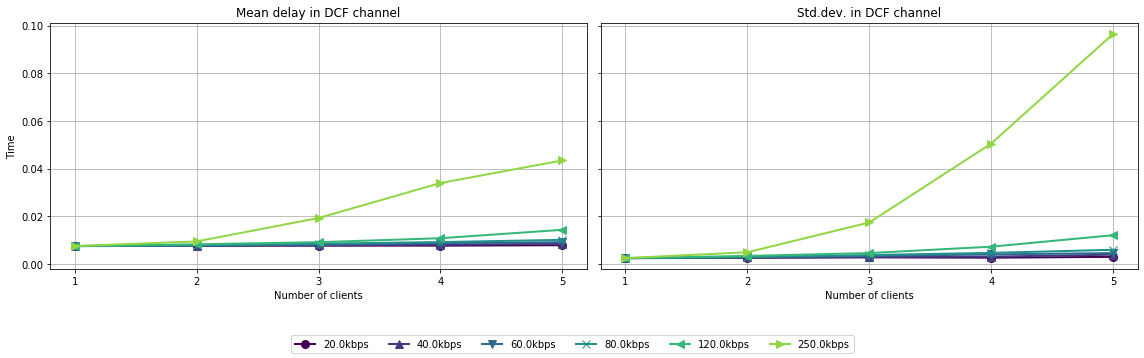

In [20]:
fig, axes = plt.subplots(figsize=(16, 5), nrows=1, ncols=2, sharey=True)

ALL_MARKERS = ['o', '^', 'v', 'x', '<', '>', 's']

for i, traffic in enumerate(DCF_TRAFFIC):
    ax0, ax1 = axes
    label    = f'{traffic / 1e3}kbps'
    color    = get_color(i / len(DCF_TRAFFIC))
    marker   = ALL_MARKERS[i % len(ALL_MARKERS)]
    records  = [r for r in dcf_channel_sim if r.traffic == traffic]
    records.sort(key=lambda r: r.num_stations)

    ax0.plot(
        DCF_CHAN_NUM_STATIONS_RANGE, [r.data.clients[0].service_time.mean() for r in records],
        linewidth=2, label=label, marker=marker, markersize=8, color=color
    )
    ax1.plot(
        DCF_CHAN_NUM_STATIONS_RANGE, [r.data.clients[0].service_time.std() for r in records],
        linewidth=2, label=label, marker=marker, markersize=8, color=color
    )
    ax0.set_ylabel(f'Time')
    ax0.set_title('Mean delay in DCF channel')
    ax1.set_title('Std.dev. in DCF channel')
    
for ax in (ax0, ax1):
    ax.grid()
    ax.set_xticks(DCF_CHAN_NUM_STATIONS_RANGE)
    ax.set_xlabel('Number of clients')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6)
plt.tight_layout()
plt.subplots_adjust(bottom=0.24)

We are most interested in three cases:

1. Channel with single (sender) station: a boundary case, one-hop network.
2. Channel with two stations: we assume that each station "hear" only its direct neighbours, so boundary stations in multi-hop networks will operate like in a channel with two stations.
3. Channel with three stations: any station in the middle of the multi-hop network have two direct neighbours, together they form something like a channel with three stations.

Note however, that it is more "like a two- (three-) stations channel", since service times will be dependent for any group of neighbour stations, so considering station `C` in a chain `... -> A -> B -> C -> D -> E -> ...` it will indirectly depend on the transmissions of stations `A` and `E`, since their transmissions affect transmissions of stations `B` and `D`. However, we assume that there is no strong dependency and use the cases we defined above to find service times for servers in the queueing tandem network.

Two better analyze these three cases, we will plot them:

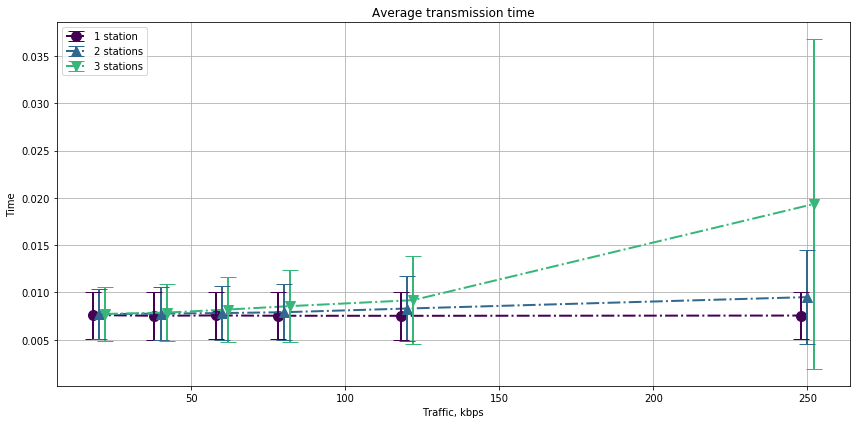

In [21]:
fig = plt.figure(figsize=(12, 6))

ALL_LINESTYLES = ['-', '--', '-.', ':']

for i, num_stations in enumerate([1, 2, 3]):
    records = [r for r in dcf_channel_sim if r.num_stations == num_stations]
    ox      = [int(traffic/1e3) + (i-1)*2 for traffic in DCF_TRAFFIC]
    records.sort(key=lambda r: r.traffic)

    stddevs  = [r.data.clients[0].service_time.std() for r in records]
    averages = [r.data.clients[0].service_time.mean() for r in records]
    errors   = [[min(e, a) for (e, a) in zip(stddevs, averages)], stddevs]
    
    marker = ALL_MARKERS[i % len(ALL_MARKERS)]
    color  = get_color(i / 3)
    linestyle = ALL_LINESTYLES[i % len(ALL_LINESTYLES)]

    _, capline, _ = plt.errorbar(
        ox, averages, yerr=errors, 
        color=color, marker=marker, linewidth=2, markersize=10, linestyle='-.',
        elinewidth=2, barsabove=True, uplims=True, lolims=True,
        label=f'{num_stations} station{"s" if num_stations > 1 else ""}')
    for cline in capline:
        cline.set_marker('_')
        cline.set_markersize(16)

plt.title('Average transmission time')
plt.xlabel('Traffic, kbps')
plt.ylabel('Time')
plt.grid()
plt.legend()
plt.tight_layout()

Now we are going to fit the service times with PH distributions. Since estimated moments values differ for channels with two or three stations for different bitrates, we are going build a separate PH distribution for each traffic bitrate and each number of stations in the channel (except the case when threre is one station, as service time in this case doesn't depend on the traffic bitrate).

In [22]:
from pyqumo.fitting import fit_ph

DCFChannelPH = namedtuple('DCFChannelPH', ['ph', 'num_stations', 'traffic'])

def fit_dcf_ph():
    ph_1   = None  # To avoid re-fitting PH for num_stations=1, we will cache it here
    nea    = []    # Here we store tuples representing expected and fitted means and std.devs
    result = []    # This will be a list of DCFChannelPH records
    for num_stations, traffic in tqdm_notebook(list(product([1, 2, 3], DCF_TRAFFIC)), desc='Fitting PH'):
        if num_stations == 1 and ph_1 is not None:
            ph = copy_ph(ph_1)
        else:
            sim = [r for r in dcf_channel_sim if r.num_stations == num_stations and r.traffic == traffic]
            assert len(sim) == 1

            service_time = sim[0].data.clients[0].service_time
            ph           = fit_ph(service_time.as_list(), order=10, method='gfit')
            
            # Filling data for precision validation:
            nea.append((f'mean for n={num_stations}, traffic={traffic/1e3}', service_time.mean(), ph.mean()))
            nea.append((f'std. for n={num_stations}, traffic={traffic/1e3}', service_time.std(), ph.std()))
            
            if num_stations == 1:
                ph_1 = ph
        
        record = DCFChannelPH(ph, num_stations, traffic)
        result.append(record)
    
    return result, nea

dcf_channel_ph, _nea = fit_dcf_ph()
print_estimations(_nea)


Name                           Expected      Actual    Std. Error
---------------------------  ----------  ----------  ------------
mean for n=1, traffic=20.0   0.00760995  0.00760995   2.27955e-16
std. for n=1, traffic=20.0   0.00247966  0.00253666   0.0229867
mean for n=2, traffic=20.0   0.00770556  0.00770556   0
std. for n=2, traffic=20.0   0.0026466   0.00272435   0.0293792
mean for n=2, traffic=40.0   0.00776631  0.00776631   5.58413e-16
std. for n=2, traffic=40.0   0.00279519  0.00293544   0.0501763
mean for n=2, traffic=60.0   0.00782278  0.00782278   4.43506e-16
std. for n=2, traffic=60.0   0.00287206  0.00300702   0.0469901
mean for n=2, traffic=80.0   0.00791074  0.00791074   0
std. for n=2, traffic=80.0   0.0029574   0.00299001   0.0110278
mean for n=2, traffic=120.0  0.00830007  0.00830007   0
std. for n=2, traffic=120.0  0.00343136  0.00345301   0.00630953
mean for n=2, traffic=250.0  0.00950945  0.00950945   1.82421e-16
std. for n=2, traffic=250.0  0.00495918  0.0049042

To simplify things further, we define a method for getting PH-distribution for a given number of stations and traffic:

In [23]:
def get_dcf_ph(num_stations, traffic):
    records = [r for r in dcf_channel_ph if r.num_stations == num_stations and r.traffic == traffic]
    assert len(records) <= 1
    if len(records) == 0:
        raise ValueError(f'PH for num_stations={num_stations} and traffic={traffic/1e3}kbps not found')
    return records[0].ph

For illustration we plot several original and fitted distributions density functions:

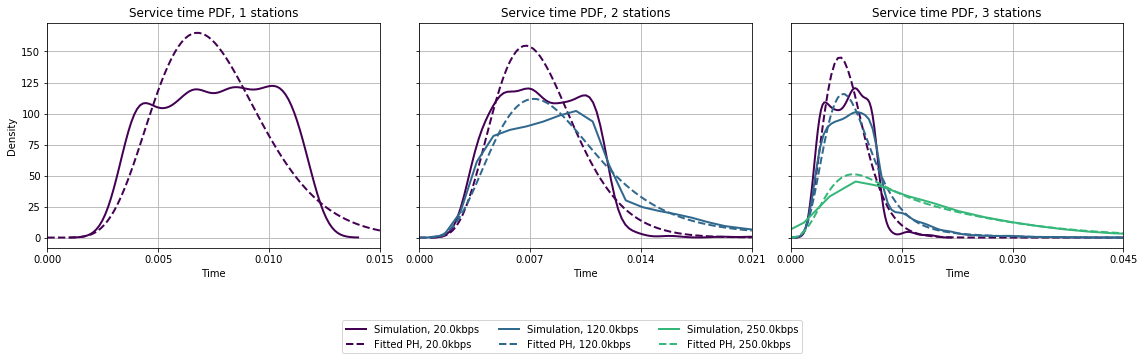

In [37]:
import seaborn as sns

fig, axes = plt.subplots(figsize=(16, 5), nrows=1, ncols=3, sharey=True)

for ax, num_stations, traffic_set, xmax in zip(
    axes, [1, 2, 3], [[20e3], [20e3, 250e3], [20e3, 120e3, 250e3]], [0.015, 0.021, 0.045]
):
    colors = [get_color(i/3) for i in range(3)]
    for i, traffic in enumerate(traffic_set):
        ox    = np.linspace(0, xmax, num=100)
        color = colors[i]
        sim_records = [r for r in dcf_channel_sim if r.num_stations == num_stations and r.traffic == traffic]

        assert len(sim_records) == 1

        sim_data = sim_records[0].data.clients[0].service_time.as_list()
        ph       = get_dcf_ph(num_stations, traffic)

        sns.distplot(sim_data, kde=True, hist=False, kde_kws={'linewidth': 2}, ax=ax, color=color,
                     label=f'Simulation, {traffic/1e3}kbps')
        ax.plot(ox, [ph.pdf(x) for x in ox], color=color, linewidth=2, linestyle='--',
                label=f'Fitted PH, {traffic/1e3}kbps')

    ax.set_xlim((0, xmax))
    ax.set_xticks(np.linspace(0, xmax, 4))
    ax.grid()
    ax.get_legend().remove()
    ax.set_title(f'Service time PDF, {num_stations} stations')
    ax.set_xlabel('Time')
    
axes[0].set_ylabel('Density')
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3)
plt.tight_layout()
plt.subplots_adjust(bottom=0.30)

To additionally visualize PH distributions, we show two (boundary) distributions: for channel with 1 station (without collisions) and for channel with 3 stations for 250 kbps traffic:

In [26]:
for num_stations, traffic in zip([1, 3], [20e3, 250e3]):
    print(f"{'-'*80}\nPH FITTED FOR {num_stations} STATIONS AND {traffic} KBPS PAYLOAD TRAFFIC\n{'-'*80}")
    np.set_printoptions(precision=2, linewidth=120)
    ph = get_dcf_ph(num_stations, traffic)
    print(f"S:\n{ph.subgenerator}")
    print(f"Initial PMF: {ph.pmf0}\n")

--------------------------------------------------------------------------------
PH FITTED FOR 1 STATIONS AND 20000.0 KBPS PAYLOAD TRAFFIC
--------------------------------------------------------------------------------
S:
[[ -155.71     0.       0.       0.       0.       0.       0.       0.       0.       0.  ]
 [    0.   -1182.66  1182.66     0.       0.       0.       0.       0.       0.       0.  ]
 [    0.       0.   -1182.66  1182.66     0.       0.       0.       0.       0.       0.  ]
 [    0.       0.       0.   -1182.66  1182.66     0.       0.       0.       0.       0.  ]
 [    0.       0.       0.       0.   -1182.66  1182.66     0.       0.       0.       0.  ]
 [    0.       0.       0.       0.       0.   -1182.66  1182.66     0.       0.       0.  ]
 [    0.       0.       0.       0.       0.       0.   -1182.66  1182.66     0.       0.  ]
 [    0.       0.       0.       0.       0.       0.       0.   -1182.66  1182.66     0.  ]
 [    0.       0.       0.       

### 3.2. DCF network simulation

In the same way as for relay network, we will simulate traffic arrival at the first station, and vary the network length from 1 to `MAX_STATIONS_NUM` for each arrival rate.

In contrast to relay network, we will not be interested much in very heavy traffic as it will flood the network very soon. As we will see, even at 120 kbps the end-to-end delay grows too much for any reasonable application.

In [27]:
from collections import namedtuple
from itertools import product
from pydesim import Logger
from pycsmaca.simulations.shortcuts import wireless_half_duplex_line_network

DCFNetworkSimRecord = namedtuple('DCFNetworkSimRecord', ['data', 'num_stations', 'traffic'])

dcf_network_sim = []  # each item will hold a namedtuple DCFNetworkSimRecord

for num_stations, traffic, in tqdm_notebook(
    list(product(NUM_STATIONS_RANGE, DCF_TRAFFIC)), 
    desc=f'Relay network simulation'
):
    rate    = traffic / PAYLOAD_MEAN
    arrival = scale_map(normalized_arrival_map, rate)
    data    = wireless_half_duplex_line_network(
        num_clients=num_stations, 
        payload_size=DCF_PAYLOAD, 
        source_interval=arrival,
        ack_size=MAC_ACK,
        active_sources=[0],
        mac_header_size=MAC_HEADER, 
        phy_header_size=PHY_HEADER, 
        preamble=PREAMBLE,
        bitrate=BITRATE, 
        difs=DIFS, 
        sifs=SIFS, 
        slot=SLOT, 
        cwmin=CWMIN, 
        cwmax=CWMAX, 
        queue_capacity=100,
        connection_radius=120,
        distance=100,
        sim_time_limit=SIM_TIME_LIMIT, 
        log_level=Logger.Level.WARNING,
    )
    record = DCFNetworkSimRecord(data, num_stations, traffic)
    dcf_network_sim.append(record)

For simplicity, we define a helper method for searching the record we actually need. It will return `data` field.

In [28]:
def get_dcf_network_sim(num_stations, traffic):
    records = [r for r in dcf_network_sim if r.num_stations == num_stations and r.traffic == traffic]
    assert len(records) <= 1
    if len(records) == 0:
        raise ValueError(f'DCF simulation for num_stations={num_stations}' 
                         f'and traffic={traffic/1e3}kbps not found')
    return records[0].data

### 3.3. DCF network modelling with queueing tandem network

Completely like in relay network, we use two approaches for network performance estimation using queueing networks:

1. Monte-Carlo estimation: a simulation of a queueing network to estimate its parameters.
2. Departure approximation: iterative estimation with departure flows approximation.

The latter approach will be used twice: in the first attempt we approximate departure MAPs with simple Poisson process (or MAP(1)) and in the second attempt we will use MAP of larger order.

The only change here is that we use different service for different networks:

1. If the network consists of only one hop, we use PH for channel with one station.
2. Otherwise, we use PH for channel with two stations for the first and the last hops, and PH for the channel three stations for all hops in the middle of the network.

#### 3.3.1. Monte-Carlo estimation
The procedure is similiar to relay network simulation: we run queueing network simulations, but using the fitted PH-distributed transmission delays as service time instead of providing payload size distributions. The queue capacity will be the same as in relay network simulation.

In [29]:
DCFQueueSimRecord = namedtuple('DCFQueueSimRecord', ['data', 'num_stations', 'traffic'])

dcf_queue_sim = []  # each item will hold a namedtuple DCFQueueSimRecord

for num_stations, traffic in tqdm_notebook(list(product(NUM_STATIONS_RANGE, DCF_TRAFFIC)), 
                                           desc=f'DCF Queueing Tandem Simulation'):
    rate     = traffic / PAYLOAD_MEAN
    arrivals = [scale_map(normalized_arrival_map, rate)] + [None] * (num_stations - 1)

    if num_stations == 1:
        services = [get_dcf_ph(1, traffic)]
    else:
        ph2      = get_dcf_ph(2, traffic)
        ph3      = get_dcf_ph(3, traffic)
        services = [copy_ph(ph2)] + [copy_ph(ph3) for _ in range(num_stations - 2)] + [copy_ph(ph2)]

    data   = tandem_queue_network(arrivals, services, queue_capacity=10, stime_limit=SIM_TIME_LIMIT)
    record = DCFQueueSimRecord(data, num_stations, traffic)
    dcf_queue_sim.append(record)

Also define a helper for getting tandem queue simulation results:

In [30]:
def get_dcf_queue_sim(num_stations, traffic):
    records = [r for r in dcf_queue_sim if r.num_stations == num_stations and r.traffic == traffic]
    assert len(records) <= 1
    if len(records) == 0:
        raise ValueError(f'DCF queueing network simulation for num_stations={num_stations}' 
                         f'and traffic={traffic/1e3}kbps not found')
    return records[0].data

#### 3.3.2. Iterative approximation

In thie method, we approximate departure process in iterative procedure for estimation of delays, queue sizes and servers utilizations.

Since here we do not simulate the whole network, results for network of size `n` is obtained at $n$-th iteration of the estimation procedure.

In [31]:
from pyqumo.queues import MapPh1N
from pyqumo.arrivals import MAP

DCF_APPROX_ORDERS = [1, 3]

DCFApproxData = namedtuple('DCFApproxData', [
    'system', 'delay', 'queue_size', 'utilization', 'approx_departure'
])

DCFQueueApproxRecord = namedtuple('DCFQueueApproxRecord', ['data', 'num_stations', 'traffic', 'approx_order'])

dcf_queue_approx = []  # each item will hold a namedtuple RelayQueueNetworkSimulationRecord

def estimate_dcf_queue_approx(traffic, approx_order):
    rate    = traffic / PAYLOAD_MEAN
    arrival = scale_map(normalized_arrival_map, rate)
    delay   = 0.0  # store current accumulated delay
    records = []

    # We separately estimate 'delay', 'queue_size' and 'utilization' for the single-hop 
    # network since here we use PH(1).
    # However, 'system' and 'approx_departure' fields will be filled when using PH(2) since they
    # become meaningful in case of a multi-hop network.
    single_hop_system = MapPh1N(arrival, get_dcf_ph(1, traffic), capacity=10)
    
    for n in tqdm_notebook(NUM_STATIONS_RANGE, desc=f'Approximation, order={approx_order}', leave=False):
        # First, we check select correct PH distribution:
        if n in {2, max(NUM_STATIONS_RANGE)}:
            service = get_dcf_ph(2, traffic)
        else:
            service = get_dcf_ph(3, traffic)
        
        # Then we build the queueing system and compute its properties.
        # Note, that if n == 1, then we use `single_hop_system` to compute delay instead
        # of the system that was actually built:
        system = MapPh1N(arrival, service, capacity=10)
        
        active_system = system if n > 1 else system
        response_time = active_system.response_time
        queue_size    = active_system.system_size_avg - active_system.utilization
        utilization   = active_system.utilization
        
        # Increase delay by the current system reponse time:
        delay += response_time
        
        # Fit the departure process with a MAP of a given order:
        if approx_order == 1:
            approx_departure = MAP.exponential(system.departure.rate)
        else:
            approx_departure = fit_map(system.departure, order=approx_order)
        
        # Finally, fill the record and set current approximated departure MAP as an arrival
        # for the next phase:
        arrival     = approx_departure
        data        = DCFApproxData(system, delay, queue_size, utilization, approx_departure)
        records.append(DCFQueueApproxRecord(data, n, traffic, approx_order))
    return records

for traffic, approx_order in tqdm_notebook(list(product(DCF_TRAFFIC, DCF_APPROX_ORDERS)),
                                           desc=f'Queueing network approx.'):
    records = estimate_dcf_queue_approx(traffic, approx_order)
    dcf_queue_approx.extend(records)

In [32]:
def get_dcf_approx(num_stations, traffic, approx_order):
    records = [r for r in dcf_queue_approx if (
        r.num_stations == num_stations and 
        r.traffic == traffic and 
        r.approx_order == approx_order
    )]
    assert len(records) <= 1
    if len(records) == 0:
        raise ValueError(f'DCF tandem approximation for num_stations={num_stations}, ' 
                         f'traffic={traffic/1e3}kbps and approx_order={approx_order} not found')
    return records[0].data

### 3.4. Comparing results

Again, now we can compare the results. As in relay network, we will be interested in three parameters:

1. End-to-end delay
2. Average queue size
3. Utilization (busy ratio)

To compare, we will plot the results for each interesting metric.

#### 3.4.1. End-to-end delays

First of all, we will compare end-to-end delays.

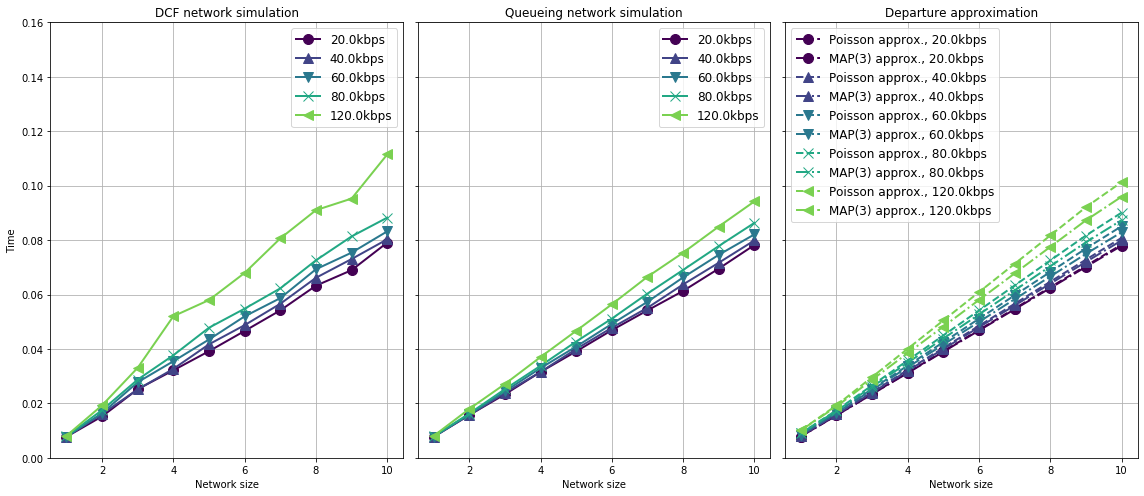

In [33]:
fig, axes = plt.subplots(figsize=(16, 7), ncols=3, sharey=True)

ALL_MARKERS = ['o', '^', 'v', 'x', '<', '>', 's']

for i, traffic in enumerate(DCF_TRAFFIC[:-1]):
    color          = get_color(i / len(DCF_TRAFFIC[:-1]))
    marker         = ALL_MARKERS[i]
    traffic_string = f'{traffic / 1e3}kbps'
    
    sim_data = [get_dcf_network_sim(n, traffic).clients[0].delay.mean() for n in NUM_STATIONS_RANGE]
    qmc_data = [get_dcf_queue_sim(n, traffic).nodes[0].delay.mean() for n in NUM_STATIONS_RANGE]
    qa1_data = [get_dcf_approx(n, traffic, 1).delay for n in NUM_STATIONS_RANGE]
    qa3_data = [get_dcf_approx(n, traffic, 3).delay for n in NUM_STATIONS_RANGE]
    
    axes[0].plot(NUM_STATIONS_RANGE, sim_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')
    axes[1].plot(NUM_STATIONS_RANGE, qmc_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')
    axes[2].plot(NUM_STATIONS_RANGE, qa1_data, color=color, marker=marker, linewidth=2, markersize=10,
                 linestyle='--', label=f'Poisson approx., {traffic_string}')
    axes[2].plot(NUM_STATIONS_RANGE, qa3_data, color=color, marker=marker, linewidth=2, markersize=10,
                 linestyle='-.', label=f'MAP(3) approx., {traffic_string}')

for ax in axes:
    ax.grid()
    ax.set_ylim((0, 0.16))
    ax.set_xlabel('Network size')
    ax.legend(fontsize=12)

axes[0].set_ylabel('Time')
axes[0].set_title('DCF network simulation')
axes[1].set_title('Queueing network simulation')
axes[2].set_title('Departure approximation')

plt.tight_layout()

Abover we excluded results for 250kbps, since end-to-end delay in simulation raises "to the sky" and reaches 12 **seconds**. We can make two conclusions from here:

1. Tandem approximation results are very close to tandem simulation, even when departure MAPs are approximated with Poisson flows.
2. Queueing network estimations are pretty close to simulation until about 80kbps of payload traffic, or even 120kbps (but for only four stations).

To understand better, what is going on, let us compare the actual service times at stations:

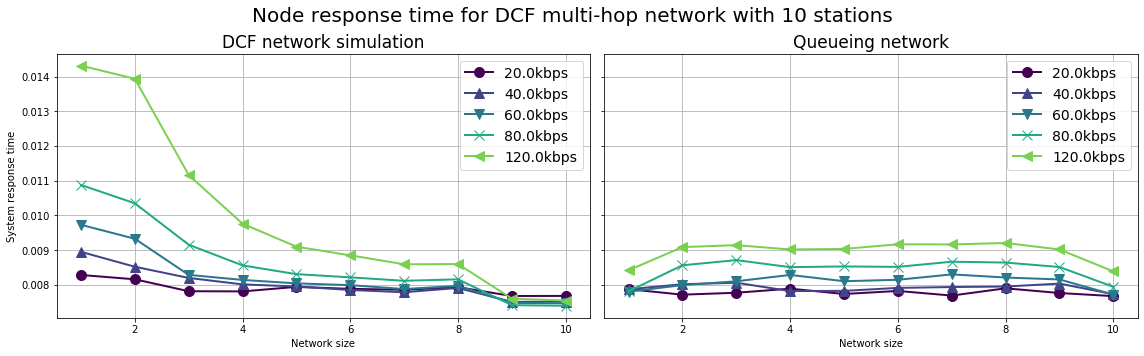

In [34]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2, sharey=True)

ALL_MARKERS = ['o', '^', 'v', 'x', '<', '>', 's']

for i, traffic in enumerate(DCF_TRAFFIC[:-1]):
    color          = get_color(i / len(DCF_TRAFFIC[:-1]))
    marker         = ALL_MARKERS[i]
    traffic_string = f'{traffic / 1e3}kbps'
    
    sim_rec = get_dcf_network_sim(MAX_STATIONS_NUM, traffic)
    qmc_rec = get_dcf_queue_sim(MAX_STATIONS_NUM, traffic)
    
    sim_data = [sim_rec.clients[n-1].service_time.mean() for n in NUM_STATIONS_RANGE]
    qmc_data = [qmc_rec.nodes[n-1].service.mean() for n in NUM_STATIONS_RANGE]
    
    axes[0].plot(NUM_STATIONS_RANGE, sim_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')
    axes[1].plot(NUM_STATIONS_RANGE, qmc_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')

for ax in axes:
    ax.grid()
    ax.set_xlabel('Network size')
    ax.legend(fontsize=14)

axes[0].set_ylabel('System response time')
axes[0].set_title('DCF network simulation', fontsize=17)
axes[1].set_title('Queueing network', fontsize=17)
fig.suptitle(f'Node response time for DCF multi-hop network with {MAX_STATIONS_NUM} stations', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.85)

These plots show that in actual network service time actually decreases, while in the queueing network we use the same service time approximations.

> It is an interesting problem to solve in further research. Effect on service time decay looks like channel capture and should be described somewhere...

#### 2.4.2. Average queue size and utilization

These metrics represent the memory and load properties of the networks.

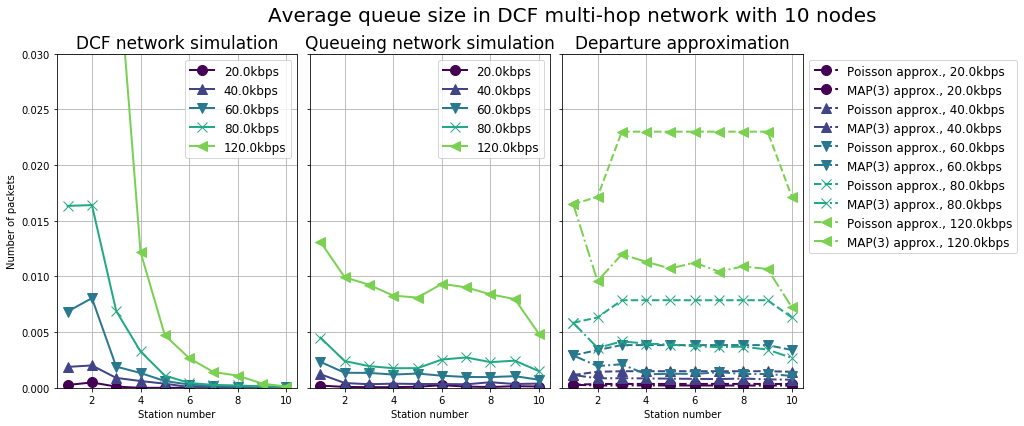

In [35]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=3, sharey=True)

ALL_MARKERS = ['o', '^', 'v', 'x', '<', '>', 's']

for i, traffic in enumerate(DCF_TRAFFIC[:-1]):
    color          = get_color(i / len(DCF_TRAFFIC[:-1]))
    marker         = ALL_MARKERS[i]
    traffic_string = f'{traffic / 1e3}kbps'
    
    sim_rec = get_dcf_network_sim(MAX_STATIONS_NUM, traffic)
    qmc_rec = get_dcf_queue_sim(MAX_STATIONS_NUM, traffic)
    
    sim_data = [sim_rec.clients[n-1].queue_size.timeavg() for n in NUM_STATIONS_RANGE]
    qmc_data = [qmc_rec.nodes[n-1].queue_size.timeavg() for n in NUM_STATIONS_RANGE]
    qa1_data = [get_dcf_approx(n, traffic, 1).queue_size for n in NUM_STATIONS_RANGE]
    qa3_data = [get_dcf_approx(n, traffic, 3).queue_size for n in NUM_STATIONS_RANGE]
    
    axes[0].plot(NUM_STATIONS_RANGE, sim_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')
    axes[1].plot(NUM_STATIONS_RANGE, qmc_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')
    axes[2].plot(NUM_STATIONS_RANGE, qa1_data, color=color, marker=marker, linewidth=2, markersize=10,
                 linestyle='--', label=f'Poisson approx., {traffic_string}')
    axes[2].plot(NUM_STATIONS_RANGE, qa3_data, color=color, marker=marker, linewidth=2, markersize=10,
                 linestyle='-.', label=f'MAP(3) approx., {traffic_string}')

for ax in axes:
    ax.grid()
    ax.set_xlabel('Station number')
    ax.set_ylim((0, 0.03))
#     ax.set_yscale('log')

axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)
axes[2].legend(bbox_to_anchor=(1.0, 1.0), fontsize=12)

axes[0].set_ylabel('Number of packets')
axes[0].set_title('DCF network simulation', fontsize=17)
axes[1].set_title('Queueing network simulation', fontsize=17)
axes[2].set_title('Departure approximation', fontsize=17)
fig.suptitle(f'Average queue size in DCF multi-hop network with {MAX_STATIONS_NUM} nodes', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(right=0.7, top=0.87)

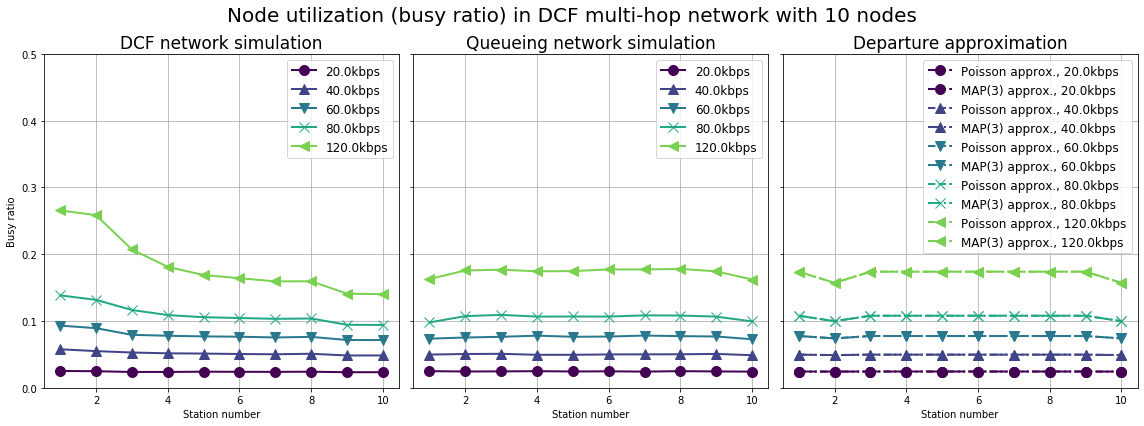

In [36]:
fig, axes = plt.subplots(figsize=(16, 6), ncols=3, sharey=True)

ALL_MARKERS = ['o', '^', 'v', 'x', '<', '>', 's']

for i, traffic in enumerate(DCF_TRAFFIC[:-1]):
    color          = get_color(i / len(DCF_TRAFFIC[:-1]))
    marker         = ALL_MARKERS[i]
    traffic_string = f'{traffic / 1e3}kbps'
    
    sim_rec = get_dcf_network_sim(MAX_STATIONS_NUM, traffic)
    qmc_rec = get_dcf_queue_sim(MAX_STATIONS_NUM, traffic)
    
    sim_data = [sim_rec.clients[n-1].tx_busy.timeavg() for n in NUM_STATIONS_RANGE]
    qmc_data = [qmc_rec.nodes[n-1].busy.timeavg() for n in NUM_STATIONS_RANGE]
    qa1_data = [get_dcf_approx(n, traffic, 1).utilization for n in NUM_STATIONS_RANGE]
    qa3_data = [get_dcf_approx(n, traffic, 3).utilization for n in NUM_STATIONS_RANGE]
    
    axes[0].plot(NUM_STATIONS_RANGE, sim_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')
    axes[1].plot(NUM_STATIONS_RANGE, qmc_data, color=color, marker=marker, linewidth=2, markersize=10,
                 label=f'{traffic_string}')
    axes[2].plot(NUM_STATIONS_RANGE, qa1_data, color=color, marker=marker, linewidth=2, markersize=10,
                 linestyle='--', label=f'Poisson approx., {traffic_string}')
    axes[2].plot(NUM_STATIONS_RANGE, qa3_data, color=color, marker=marker, linewidth=2, markersize=10,
                 linestyle='-.', label=f'MAP(3) approx., {traffic_string}')

for ax in axes:
    ax.grid()
    ax.set_xlabel('Station number')
    ax.set_ylim((0, 0.5))
#     ax.set_yscale('log')

axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)
axes[2].legend(bbox_to_anchor=(1.0, 1.0), fontsize=12)

axes[0].set_ylabel('Busy ratio')
axes[0].set_title('DCF network simulation', fontsize=17)
axes[1].set_title('Queueing network simulation', fontsize=17)
axes[2].set_title('Departure approximation', fontsize=17)
fig.suptitle(f'Node utilization (busy ratio) in DCF multi-hop network with {MAX_STATIONS_NUM} nodes', fontsize=20)

plt.tight_layout()
plt.subplots_adjust(top=0.87)